In [30]:
import numpy as np
import pandas as pd
import os
from matplotlib.pyplot import *
import h5py
import scipy.stats as sts

from ATARI.syndat.particle_pair import Particle_Pair
from ATARI.syndat.experiment import Experiment
from ATARI.syndat.MMDA import generate
from ATARI.theory.xs import SLBW
from ATARI.theory.scattering_params import FofE_recursive
from ATARI.theory.scattering_params import gstat
from ATARI.utils.datacontainer import DataContainer
from ATARI.utils.atario import fill_resonance_ladder

from numpy.linalg import inv
from scipy.linalg import block_diag

from scipy.optimize import lsq_linear
from qpsolvers import solve_qp
from scipy.optimize import linprog

import functions as fn 


In [31]:
%matplotlib widget

In [32]:
(2500/0.1)*(50/0.1)

12500000.0

/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:502: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


(-7.675283643313486, 95.94104554141857)

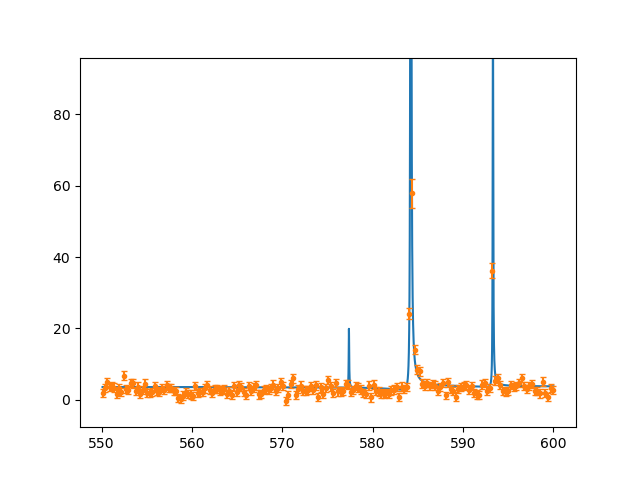

In [49]:

ac = 0.81271  # scattering radius in 1e-12 cm 
M = 180.948030  # amu of target nucleus
m = 1           # amu of incident neutron
I = 3.5         # intrinsic spin, positive parity
i = 0.5         # intrinsic spin, positive parity
l_max = 1       # highest order l-wave to consider


Ta_pair = Particle_Pair( ac, M, m, I, i, l_max,
                                input_options={})



spin_groups = [ (3.0,1,0)] # , (4.0,1,[0]) ]
average_parameters = pd.DataFrame({ 'dE'    :   {'3.0':8.79, '4.0':4.99},
                                    'Gg'    :   {'3.0':64.0, '4.0':64.0},
                                    'gn2'    :   {'3.0':46.4, '4.0':35.5}  })


E_min_max = [550, 600]
energy_grid = E_min_max

input_options = {'Add Noise': True,
                'Calculate Covariance': True,
                'Compression Points':[],
                'Grouping Factors':None}

experiment_parameters = {'bw': {'val':0.0256,   'unc'   :   0},
                         'n':  {'val':0.06,     'unc'   :0}}

# initialize experimental setup
exp = Experiment(energy_grid, 
                        input_options=input_options, 
                        experiment_parameters=experiment_parameters)


resonance_ladder = Ta_pair.sample_resonance_ladder(E_min_max, spin_groups, average_parameters, False)
# resonance_ladder = pd.DataFrame({'E':[570], 'J':[3.0], 'chs':[1.0], 'lwave':[0.0], 'J_ID':[1.0], 'gnx2':[100], 'Gg':[750]})
# resonance_ladder = pd.DataFrame({'E':[575], 'J':[3.0], 'chs':[1.0], 'lwave':[0.0], 'J_ID':[1.0], 'gnx2':[5000], 'Gg':[75]})
true, _, _ = SLBW(exp.energy_domain, Ta_pair, resonance_ladder)
df_true = pd.DataFrame({'E':exp.energy_domain, 'theo_trans':np.exp(-exp.redpar.val.n*true)})

exp.run(df_true)

from ATARI.utils.datacontainer import DataContainer
from ATARI.theory.experimental import trans_2_xs

dc = DataContainer()
dc.add_theoretical(Ta_pair, resonance_ladder)
threshold_0T = 1e-2
dc.add_experimental(exp, threshold=threshold_0T)

max_xs, _ = trans_2_xs(threshold_0T, dc.n)

figure()
plot(dc.pw_fine.E, dc.pw_fine.theo_xs)
errorbar(dc.pw_exp.E, dc.pw_exp.exp_xs, yerr=dc.pw_exp.exp_xs_unc, fmt='.', capsize=2)
ylim([-max_xs*.1, max_xs*1.25])


## Full feature bank and unconstrained solve

In [46]:
# Gts = []
# for i in range(1000):
#     resonance_ladder = Ta_pair.sample_resonance_ladder(E_min_max, spin_groups, average_parameters, False)
#     dc.add_theoretical(Ta_pair, resonance_ladder)
#     Gts.extend(np.array(resonance_ladder.Gt))

# print(min(Gts))
# print(max(Gts))

In [50]:
average_parameters.loc[:,['Gn']] = average_parameters['gn2']/12.5
Elam_features, Gtot_features = fn.get_parameter_grid(energy_grid, average_parameters, '3.0', 1e-1, 1e0)
Gtot_features = np.round(np.array(resonance_ladder.Gt),1)*1e-3
# Elam_features = np.round(np.array(resonance_ladder.E),1)
# Elam_features = Elam_features[0:int(len(Elam_features)/2)]
# Gtot_features = Gtot_features[::2]

# get resonance feature matrix
Resonance_Matrix, potential_scattering = fn.get_resonance_feature_bank(dc.pw_exp.E, dc.particle_pair, Elam_features, Gtot_features)
nfeatures = np.shape(Resonance_Matrix)[1]
print(nfeatures)
print(Gtot_features)

2004
[0.0661 0.061  0.0863 0.0713]


In [51]:
P, q, G, h, lb, ub, index_0T = fn.get_qp_inputs(np.array(dc.pw_exp.exp_xs), np.array(dc.CovXS), potential_scattering.flatten(), max_xs, Resonance_Matrix)

In [52]:
### consider using a sparse matrix solver and just forcing elements of P to zero below some threshold
# can also make resonance matrix and datacov sparse (can make datacov or invdatacov sparse)


# figure()
# # plot(np.array(dc.CovXS)[100,:])
# # imshow(np.log10(np.array(dc.CovXS)))
# plot(np.diag(np.array(dc.CovXS)))

# test = Resonance_Matrix.copy()
# test[abs(Resonance_Matrix)<10] = 0
# testcov = np.array(dc.CovXS).copy()
# testcov[abs(testcov)<0.15] = 0 

# P, q, G, h, lb, ub, index_0T = fn.get_qp_inputs(dc.pw_exp.exp_xs, testcov, potential_scattering.flatten(), max_xs, test)
# # test = P
# # test[abs(P)<30000] = 0

# figure()
# # bins = hist(np.log10(P[1000,:]), bins=25)
# # plot(test[2000,:])
# # plot(test[:,3000])
# spy(P)



In [53]:
unconstrained_w = solve_qp(P, q, G=G, h=h, A=None, b=None, lb=lb, ub=ub, 
                                                                solver="cvxopt",
                                                                verbose=True,
                                                                abstol=1e-11,
                                                                reltol=1e-11,
                                                                feastol= 1e-7,
                                                                maxiters = 200)

print(np.count_nonzero(unconstrained_w>1e-10))

     pcost       dcost       gap    pres   dres
 0: -4.7958e+02 -3.4063e+03  1e+04  2e+00  2e-13
 1: -4.7958e+02 -1.8817e+03  2e+03  3e-01  1e-13
 2: -4.7956e+02 -1.1176e+03  1e+03  1e-01  1e-13
 3: -4.7954e+02 -5.6134e+02  1e+02  1e-02  4e-14
 4: -4.7954e+02 -4.8573e+02  1e+01  1e-03  6e-15
 5: -4.7951e+02 -4.8431e+02  9e+00  7e-04  4e-15
 6: -4.7941e+02 -4.8274e+02  8e+00  6e-04  4e-15
 7: -4.7906e+02 -4.8035e+02  9e+00  5e-04  3e-15
 8: -4.7764e+02 -4.7588e+02  9e+00  4e-04  3e-15
 9: -4.7469e+02 -4.7119e+02  8e+00  3e-04  2e-15
10: -4.7326e+02 -4.6974e+02  8e+00  3e-04  2e-15
11: -4.6928e+02 -4.6661e+02  6e+00  2e-04  1e-15
12: -4.6776e+02 -4.6566e+02  5e+00  1e-04  8e-16
13: -4.6550e+02 -4.6456e+02  3e+00  6e-05  7e-16
14: -4.6300e+02 -4.6362e+02  1e+00  5e-06  9e-16
15: -4.6299e+02 -4.6322e+02  3e-01  1e-06  7e-16
16: -4.6299e+02 -4.6315e+02  2e-01  5e-07  6e-16
17: -4.6302e+02 -4.6306e+02  5e-02  1e-07  7e-16
18: -4.6303e+02 -4.6305e+02  2e-02  2e-08  7e-16
19: -4.6303e+02 -4.63

### Now perform bisection method to find weight constraints for integer number of resonances

In [54]:
## Find minimum solvable weight

c = np.ones_like(unconstrained_w)
lp_minw = linprog(c, A_ub=G, b_ub=h, bounds=np.array([lb, ub]).T)
min_wcon = np.sum(lp_minw.x)

/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:502: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


(-5.0, 115.12925464970229)

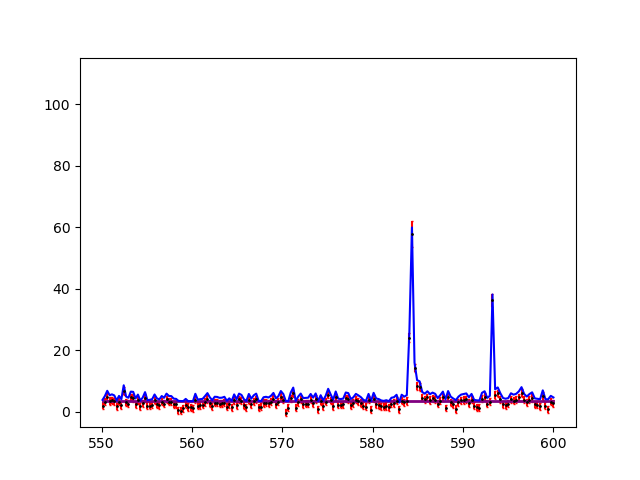

In [55]:
figure()
errorbar(dc.pw_exp.E, dc.pw_exp.exp_xs, yerr=np.sqrt(np.diag(dc.CovXS)), fmt='.', ecolor='r', color='k', capsize=1, ms=2)
plot(dc.pw_exp.E, Resonance_Matrix@lp_minw.x+potential_scattering.flatten(), lw=2, color='purple')
plot(dc.pw_exp.E, Resonance_Matrix@unconstrained_w+potential_scattering.flatten(), color='blue')

ylim([-5, max_xs*1.5])


In [56]:
def solve_qp_w_constraint(P, q, G, h, lb, ub, w_constraint, w_threshold=1e-10, verbose_bool = False):
    G_wc = np.vstack([G,np.ones(len(P))])
    h_wc = np.append(h, w_constraint)
    qp_res_c = solve_qp(P, q, G=G_wc, h=h_wc, A=None, b=None, lb=lb, ub=ub, 
                                                        solver="cvxopt",
                                                        verbose=verbose_bool,
                                                        abstol=1e-7,
                                                        reltol=1e-7,
                                                        feastol= 1e-7,
                                                        maxiters = 200) 
    if qp_res_c is None:
        _ =0 
    return qp_res_c, np.count_nonzero(qp_res_c>w_threshold)

In [57]:

def solve_wcons(ws, maxres, numres_wcon, solution_ws):
    for w in ws:
        try:
            constrained_ws, numres = solve_qp_w_constraint(P, q, G, h, lb, ub, w, w_threshold, verbose_bool=False)
            print(f'{numres} resonance solution found at w={w}')
            solution = True
        except:
            print(f'Failed at weight: {w}')
            solution = False
            if w > numres_wcon[1, 0]:
                numres_wcon[1, 0] =  w

        if solution:
            if numres >= maxres:
                numres_wcon = np.concatenate((numres_wcon,np.array([[numres], [w]])), axis=1)
            else:
                numres_wcon[1, numres] = w
                solution_ws[:, numres] = constrained_ws 
    return numres_wcon, solution_ws

def bisect_and_get_new_wcons(numres_wcon):

    found = numres_wcon[:, numres_wcon[1,:]!=0]
    notfound = numres_wcon[:, numres_wcon[1,:]==0]

    est_indices = np.searchsorted(found[0,:],notfound[0,:])
    ub_search_interval, ub_search_interval_counts = np.unique(found[:,est_indices], return_counts=True, axis=1)

    new_w = np.array([])
    for iub, vub in enumerate(ub_search_interval[1,:]):
        if iub == 0:
            lower = numres_wcon[1,0]
        else:
            lower = ub_search_interval[1, iub-1]
        upper = ub_search_interval[1, iub]
        new_w = np.append(new_w, np.linspace(lower, upper, ub_search_interval_counts[iub]+1, endpoint=False)[1::])

    return new_w


w_threshold = 1e-10
max_wcon = np.sum(unconstrained_w)
max_numres = np.count_nonzero(unconstrained_w>w_threshold)
min_wcon_solw, min_numres = solve_qp_w_constraint(P, q, G, h, lb, ub, min_wcon, w_threshold, verbose_bool=True)


     pcost       dcost       gap    pres   dres
 0: -4.7959e+02 -2.4857e+03  1e+04  3e+00  2e-03
 1: -4.7959e+02 -1.3843e+03  1e+03  3e-02  2e-05
 2: -4.7959e+02 -5.1934e+02  4e+01  1e-03  6e-07
 3: -4.7959e+02 -5.0680e+02  3e+01  7e-04  4e-07
 4: -4.7958e+02 -5.0521e+02  3e+01  7e-04  4e-07
 5: -4.7942e+02 -5.0086e+02  3e+01  6e-04  3e-07
 6: -4.7731e+02 -4.8901e+02  3e+01  4e-04  2e-07
 7: -4.7562e+02 -4.8056e+02  3e+01  4e-04  2e-07
 8: -4.7394e+02 -4.7121e+02  3e+01  3e-04  2e-07
 9: -4.7331e+02 -4.6737e+02  3e+01  3e-04  2e-07
10: -4.7101e+02 -4.5517e+02  3e+01  3e-04  1e-07
11: -4.6884e+02 -4.4418e+02  3e+01  2e-04  1e-07
12: -4.6413e+02 -4.2506e+02  3e+01  2e-04  1e-07
13: -4.5830e+02 -4.0496e+02  4e+01  2e-04  1e-07
14: -4.5123e+02 -3.8369e+02  4e+01  2e-04  1e-07
15: -4.4206e+02 -3.5969e+02  5e+01  2e-04  9e-08
16: -4.3127e+02 -3.3499e+02  6e+01  1e-04  8e-08
17: -4.1961e+02 -3.1168e+02  6e+01  1e-04  7e-08
18: -4.0681e+02 -2.8748e+02  7e+01  1e-04  7e-08
19: -3.9347e+02 -2.63

In [58]:
def bisect(x0,x1):
    # return x0 + (x1-x0)/2
    return (x0+x1)/2

def bisect_and_solve(current_target_ires, minval, maxval, target_numres, maxw_outside_target, wcon, sol_ws):
    
    icurrent_target_ires = current_target_ires-min(target_numres)

    while wcon[icurrent_target_ires] == 0:

        # bisect and solve
        new_w = bisect(minval, maxval)
        con_sol_ws, numres_sol = solve_qp_w_constraint(P, q, G, h, lb, ub, new_w, w_threshold, verbose_bool=False)
        ires_sol = numres_sol-min(target_numres)

        # get a smaller maxval if solved for numres above max target
        if new_w < maxw_outside_target and numres_sol > target_numres[-1]:
            maxw_outside_target = new_w

        if numres_sol == current_target_ires:
            #record if current target
            if wcon[ires_sol] < new_w:
                wcon[ires_sol] = new_w
                sol_ws[:,ires_sol] = con_sol_ws

        elif numres_sol > current_target_ires:
            # record other if in target numres
            if numres_sol in target_numres:
                if wcon[ires_sol] < new_w:
                    wcon[ires_sol] = new_w
                    sol_ws[:,ires_sol] = con_sol_ws
            # bisect again to find current target
            wcon, sol_ws, maxw_outside_target = bisect_and_solve(current_target_ires, minval, new_w, target_numres, maxw_outside_target, wcon, sol_ws)

        elif numres_sol < current_target_ires:
            # record other if in target numres
            if numres_sol in target_numres:
                if wcon[ires_sol] < new_w:
                    wcon[ires_sol] = new_w
                    sol_ws[:,ires_sol] = con_sol_ws
            # bisect again to find current target
            wcon, sol_ws, maxw_outside_target = bisect_and_solve(current_target_ires, new_w, maxval, target_numres, maxw_outside_target, wcon, sol_ws)

    return wcon, sol_ws, maxw_outside_target

### Improvements

still fails sometimes when running a huge feature matrix??

In [59]:
target_maxres = 10
target_maxres = np.min([target_maxres,max_numres])

target_numres = np.arange(min_numres, target_maxres+1, 1)
wcon = np.zeros(len(target_numres))
if min_wcon == 0:
    min_wcon = 1e-10
wcon[0] = min_wcon
sol_ws = np.zeros((nfeatures, len(target_numres)))
sol_ws[:, 0] = min_wcon_solw

print(target_numres)
print(wcon)

current_target_ires = target_maxres
maxw_outside_target = max_wcon 
while np.any(wcon==0):
    if wcon[-1] == 0:
        wcon, sol_ws, maxw_outside_target = bisect_and_solve(current_target_ires, min_wcon, maxw_outside_target, target_numres, maxw_outside_target, wcon, sol_ws)
    else:
        wcon, sol_ws, maxw_outside_target = bisect_and_solve(current_target_ires, min_wcon, wcon[current_target_ires-min(target_numres)+1], target_numres, maxw_outside_target, wcon, sol_ws)
    current_target_ires -= 1

# current_target_ires = min_numres+1
# maxw_outside_target = max_wcon 
# while np.any(wcon==0):
#     if wcon[-1] == 0:
#         wcon, sol_ws, maxw_outside_target = bisect_and_solve(current_target_ires, min_wcon, max_wcon, target_numres, maxw_outside_target, wcon, sol_ws)
#     else:
#         wcon, sol_ws, maxw_outside_target = bisect_and_solve(current_target_ires, min_wcon, wcon[-1], target_numres, maxw_outside_target, wcon, sol_ws)
#     current_target_ires += 1
print(target_numres)
print(wcon)

[ 0  1  2  3  4  5  6  7  8  9 10]
[1.e-10 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00]
[ 0  1  2  3  4  5  6  7  8  9 10]
[1.00000000e-10 1.93621832e-04 3.09794782e-03 6.19589554e-03
 1.23917910e-02 2.47835819e-02 3.71753727e-02 4.50170529e-02
 4.57431344e-02 4.64692159e-02 4.95671636e-02]


In [ ]:
test, testi = solve_qp_w_constraint(P, q, G, h, lb, ub, wcon[0], w_threshold, verbose_bool=False)
# (test - sol_ws[:,0])

In [60]:
sol_ws[:,0]

array([-9.42312748e-17, -9.28279729e-17, -1.00082133e-16, ...,
       -9.34264339e-17, -9.24197602e-17, -9.26229415e-17])

In [61]:
index_found = np.argwhere(wcon!=0).flatten()
print(wcon[index_found])
wcon[index_found[0:-1]]+np.diff(wcon[index_found])/2

[1.00000000e-10 1.93621832e-04 3.09794782e-03 6.19589554e-03
 1.23917910e-02 2.47835819e-02 3.71753727e-02 4.50170529e-02
 4.57431344e-02 4.64692159e-02 4.95671636e-02]


array([9.68109662e-05, 1.64578483e-03, 4.64692168e-03, 9.29384326e-03,
       1.85876864e-02, 3.09794773e-02, 4.10962128e-02, 4.53800936e-02,
       4.61061751e-02, 4.80181898e-02])

## Solve unconstrained problem with reduced feature matrix

In [62]:
from scipy.integrate import trapezoid
from ATARI.utils.misc import fine_egrid
from ATARI.utils.atario import fill_resonance_ladder
from ATARI.utils.stats import chi2_val

def calculate_integral_FoMs(weights, Elam_features, Gtot_features, threshold, datacon):
    est_resonance_ladder = fn.get_resonance_ladder_from_feature_bank(weights, Elam_features, Gtot_features, threshold)
    est_resonance_ladder = fill_resonance_ladder(est_resonance_ladder, Ta_pair, J=3.0, chs=1.0, lwave=0.0, J_ID=1.0)

    xs = Resonance_Matrix@weights+potential_scattering.flatten()
    trans = np.exp(-exp.redpar.val.n*xs)

    fineE = fine_egrid(datacon.pw_exp.E, 1e2)
    est_xs_tot, _, _ = SLBW(fineE, datacon.particle_pair, est_resonance_ladder)
    theo_xs_tot, _, _ = SLBW(fineE, datacon.particle_pair, datacon.theo_resonance_ladder)
    MSE = trapezoid((est_xs_tot-theo_xs_tot)**2, fineE)
    bias = est_xs_tot-theo_xs_tot

    return MSE, bias


def get_reduced_feature_matrix(full_feature_matrix, solution_ws, w_threshold, Elam_features, Gtot_features):
    # reduce feature bank
    index_w_surviving = np.argwhere(solution_ws>w_threshold).flatten()
    reduced_feature_matrix = full_feature_matrix[:, index_w_surviving]
    # map to surviving features 
    Efeature_index, Gfeature_index = divmod(index_w_surviving, len(Gtot_features))
    Elam_features_reduced = Elam_features[np.unique(Efeature_index)]
    Gtot_features_reduced = Gtot_features[np.unique(Gfeature_index)]
    return reduced_feature_matrix, Elam_features_reduced, Gtot_features_reduced


In [63]:
Gtot_features

array([0.0661, 0.061 , 0.0863, 0.0713])

In [64]:
def remove_nan_values(full_xs, full_cov, full_pscat, full_feature_matrix):
    index_0T = np.argwhere(np.isnan(full_xs)).flatten()
    index_finiteT = np.argwhere(np.isfinite(full_xs)).flatten()

    cov = full_cov.copy()[index_finiteT, :]
    cov = cov[:, index_finiteT]

    xs = full_xs[index_finiteT]
    pscat = full_pscat[index_finiteT]

    feature_matrix = full_feature_matrix[index_finiteT, :]

    return xs, cov, pscat, feature_matrix, index_0T

In [65]:

dc = DataContainer()
dc.add_theoretical(Ta_pair, resonance_ladder)
threshold_0T = 1e-2
dc.add_experimental(exp, threshold=threshold_0T)

In [66]:
inumres = 1

# constrained
constrained_solution = sol_ws[:, inumres]

est_resonance_ladder = fn.get_resonance_ladder_from_feature_bank(constrained_solution, Elam_features, Gtot_features, 1e-10)
# xs = Resonance_Matrix@constrained_solution+potential_scattering.flatten()
# trans = np.exp(-exp.redpar.val.n*xs)
# est_resonance_ladder  = fill_resonance_ladder(est_resonance_ladder, dc.particle_pair, J=3.0, chs=1.0, lwave=0.0, J_ID=1.0)
# fineE = fine_egrid(dc.pw_exp.E, 1e2)
# est_xs_tot, _, _ = SLBW(fineE, dc.particle_pair, est_resonance_ladder)
dc.add_estimate(est_resonance_ladder, est_name=f'est_{inumres}_con')

# theo 
# theo_xs_tot, _, _ = SLBW(fineE, dc.particle_pair, dc.theo_resonance_ladder)

# unconstrained reduced
reduced_feature_matrix, Elam_features_reduced, Gtot_features_reduced = get_reduced_feature_matrix(Resonance_Matrix, 
                                                                                                constrained_solution, 
                                                                                                w_threshold, 
                                                                                                Elam_features, 
                                                                                                Gtot_features)

P_reduced, q_reduced, G_reduced, h_reduced, lb_reduced, ub_reduced, index_0T_reduced = fn.get_qp_inputs(np.array(dc.pw_exp.exp_xs), 
                                                                                                        np.array(dc.CovXS), potential_scattering.flatten(), 
                                                                                                        max_xs, reduced_feature_matrix)

unconstrained_w_reduced = solve_qp(P_reduced, q_reduced, G=G_reduced, h=h_reduced, A=None, b=None, lb=lb_reduced, ub=ub_reduced, 
                                                                                                solver="cvxopt",
                                                                                                verbose=False,
                                                                                                abstol=1e-12,
                                                                                                reltol=1e-12,
                                                                                                feastol= 1e-8,
                                                                                                maxiters = 100)

est_resonance_ladder_reduced = fn.get_resonance_ladder_from_feature_bank(unconstrained_w_reduced, Elam_features_reduced, Gtot_features_reduced, 1e-10)
# xs_reduced = reduced_feature_matrix@unconstrained_w_reduced+potential_scattering.flatten()
# trans_reduced = np.exp(-exp.redpar.val.n*xs_reduced)
# est_resonance_ladder_reduced  = fill_resonance_ladder(est_resonance_ladder_reduced, dc.particle_pair, J=3.0, chs=1.0, lwave=0.0, J_ID=1.0)
# est_xs_tot_reduced, _, _ = SLBW(fineE, dc.particle_pair, est_resonance_ladder_reduced)
dc.add_estimate(est_resonance_ladder_reduced, est_name=f'est_{inumres}')

exp_xs, exp_cov, _, _, index_0T = remove_nan_values( np.array(dc.pw_exp.exp_xs), np.array(dc.CovXS), potential_scattering.flatten(), Resonance_Matrix) 


xs = np.array(dc.pw_exp[f'est_{inumres}_con_xs'])
xs_reduced = np.array(dc.pw_exp[f'est_{inumres}_xs'])

print(chi2_val( np.delete(xs,index_0T) , exp_xs, exp_cov).flatten())
print(chi2_val( np.delete(xs_reduced,index_0T), exp_xs, exp_cov).flatten())

[955.25072315]
[874.52236449]


In [67]:
xs[xs!=xs[index_0T]] 
len(np.array(dc.pw_exp[f'est_{inumres}_con_xs']))

/var/folders/s9/xdv2y9hs0y7g3zzscy35rz4c0000gn/T/ipykernel_4188/754342029.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  xs[xs!=xs[index_0T]]


181

In [68]:
index_0T

array([], dtype=int64)

/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:502: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


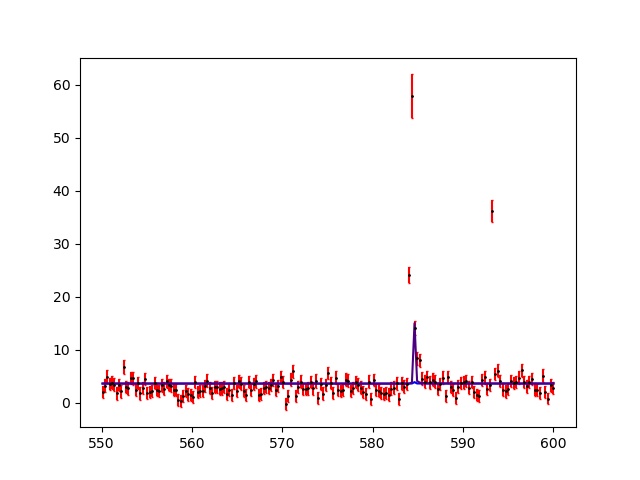

In [69]:
figure()

errorbar(dc.pw_exp.E, dc.pw_exp.exp_xs, yerr=np.sqrt(np.diag(dc.CovXS)), fmt='.', ecolor='r', color='k', capsize=1, ms=2)
# plot(dc.pw_exp.E, reduced_feature_matrix@unconstrained_w_reduced+potential_scattering.flatten(), color='blue')
# plot(dc.pw_exp.E, Resonance_Matrix@constrained_solution+potential_scattering.flatten(), color='purple')


plot(dc.pw_exp.E, xs, color='blue')
plot(dc.pw_exp.E, xs_reduced, color='indigo')

# plot(dc.pw_fine.E, est_xs_tot, color='blue')
# plot(dc.pw_fine.E, est_xs_tot_reduced, color='purple')


# plot(dc.pw_exp.E, dc.pw_exp[f'est_{inumres}_xs'], 'g')
# # plot(dc.pw_fine.E, dc.pw_fine.theo_xs, 'g')
# plot(dc.pw_fine.E, dc.pw_fine.est_1_xs)
# plot(dc.pw_exp.E, reduced_feature_matrix, 'r')

# scatter(np.array(dc.pw_exp.E)[index_0T], np.ones(len(index_0T))*max_xs)
# ylim([-5, max_xs*1.5])

In [70]:
chi2 = []
chi2_trans = []
MSE = []
mean_bias = []
std_bias = []

chi2_trans_con = []
chi2_con = []
MSE_con = []
mean_bias_con = []
std_bias_con = []

# get experimental and true solutions
exp_xs, exp_cov, _, _, index_0T = remove_nan_values( np.array(dc.pw_exp.exp_xs), np.array(dc.CovXS), potential_scattering.flatten(), Resonance_Matrix) 

for inumres, numres in enumerate(target_numres):

    # constrained
    constrained_solution = sol_ws[:, inumres]

    est_resonance_ladder = fn.get_resonance_ladder_from_feature_bank(constrained_solution, Elam_features, Gtot_features, 1e-10)
    dc.add_estimate(est_resonance_ladder, est_name=f'est_{inumres}_con')

    # unconstrained reduced
    reduced_feature_matrix, Elam_features_reduced, Gtot_features_reduced = get_reduced_feature_matrix(Resonance_Matrix, 
                                                                                                    constrained_solution, 
                                                                                                    w_threshold, 
                                                                                                    Elam_features, 
                                                                                                    Gtot_features)

    P_reduced, q_reduced, G_reduced, h_reduced, lb_reduced, ub_reduced, index_0T_reduced = fn.get_qp_inputs(np.array(dc.pw_exp.exp_xs), 
                                                                                                            np.array(dc.CovXS), potential_scattering.flatten(), 
                                                                                                            max_xs, reduced_feature_matrix)

    unconstrained_w_reduced = solve_qp(P_reduced, q_reduced, G=G_reduced, h=h_reduced, A=None, b=None, lb=lb_reduced, ub=ub_reduced, 
                                                                                                    solver="cvxopt",
                                                                                                    verbose=False,
                                                                                                    abstol=1e-12,
                                                                                                    reltol=1e-12,
                                                                                                    feastol= 1e-8,
                                                                                                    maxiters = 100)

    est_resonance_ladder_reduced = fn.get_resonance_ladder_from_feature_bank(unconstrained_w_reduced, Elam_features_reduced, Gtot_features_reduced, 1e-10)
    dc.add_estimate(est_resonance_ladder_reduced, est_name=f'est_{inumres}')

    xs = np.array(dc.pw_exp[f'est_{inumres}_con_xs'])
    xs_reduced = np.array(dc.pw_exp[f'est_{inumres}_xs'])
    trans = np.array(dc.pw_exp[f'est_{inumres}_con_trans'])
    trans_reduced = np.array(dc.pw_exp[f'est_{inumres}_trans'])

    chi2_con.append(chi2_val( np.delete(xs,index_0T) , exp_xs, exp_cov).flatten())
    chi2.append(chi2_val( np.delete(xs_reduced,index_0T), exp_xs, exp_cov).flatten())
    chi2_trans_con.append( chi2_val( trans , dc.pw_exp.exp_trans, dc.CovT).flatten() )
    chi2_trans.append( chi2_val( trans_reduced , dc.pw_exp.exp_trans, dc.CovT).flatten() )

    MSE_con.append( trapezoid((dc.pw_fine[f'est_{inumres}_con_xs']-dc.pw_fine.theo_xs)**2, dc.pw_fine.E) )
    MSE.append( trapezoid((dc.pw_fine[f'est_{inumres}_xs']-dc.pw_fine.theo_xs)**2, dc.pw_fine.E) )

    bias_con = dc.pw_fine[f'est_{inumres}_con_xs']-dc.pw_fine.theo_xs
    bias = dc.pw_fine[f'est_{inumres}_xs']-dc.pw_fine.theo_xs
    mean_bias_con.append(np.mean(bias_con))
    std_bias_con.append(np.std(bias_con))
    mean_bias.append(np.mean(bias))
    std_bias.append(np.std(bias))


/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:502: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


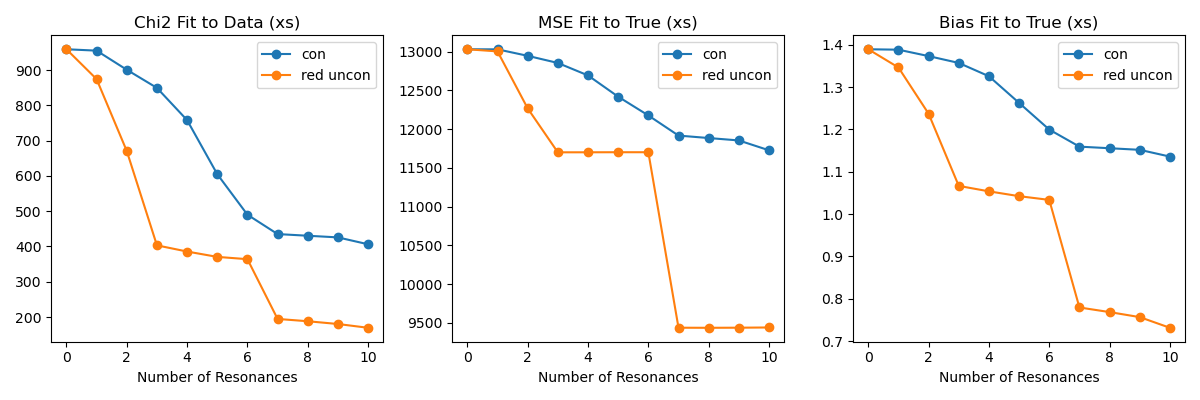

In [71]:
# figure()
# plot(target_numres, chi2_con, '-o', label='constrained')
# plot(target_numres, chi2, '-o',label='reduced unconstrained')
# plot(target_numres, MSE_con, '-o', label='constrained')
# plot(target_numres, MSE, '-o',label='reduced unconstrained')
# plot(target_numres, abs(np.array(mean_bias_con)), '-o', label='constrained')
# plot(target_numres, abs(np.array(mean_bias)), '-o',label='reduced unconstrained')
# legend()

fig, axes = subplots(1,3, figsize=(12,4))

axes[0].plot(target_numres, chi2_con, '-o', label='con')
axes[0].plot(target_numres, chi2, '-o',label='red uncon')
axes[1].plot(target_numres, MSE_con, '-o', label='con')
axes[1].plot(target_numres, MSE, '-o',label='red uncon')

# axes[2].errorbar(target_numres, abs(np.array(mean_bias_con)), yerr =(std_bias_con), fmt='.', label='con')
# axes[2].errorbar(target_numres, abs(np.array(mean_bias)), yerr =(std_bias), fmt='.', label='red uncon')
axes[2].plot(target_numres, abs(np.array(mean_bias_con)), '-o', label='con')
axes[2].plot(target_numres, abs(np.array(mean_bias)), '-o',label='red uncon')

for ax in axes:
    ax.legend()
    ax.set_xlabel('Number of Resonances')

axes[0].set_title('Chi2 Fit to Data (xs)')
axes[1].set_title('MSE Fit to True (xs)')
axes[2].set_title('Bias Fit to True (xs)')

fig.tight_layout()

In [ ]:
### fine grid weight versus constraint
# x_constrained = []

# for fac in np.linspace(0,0.6,200):
#     G_wc = np.vstack([G,np.ones(len(unconstrained_w))])
#     h_wc = np.append(h, unconstrained_weight*fac)
#     res = solve_qp(P, q, G=G_wc, h=h_wc, A=None, b=None, lb=lb, ub=ub, 
#                                                         solver="cvxopt",
#                                                         verbose=False,
#                                                         abstol=1e-10,
#                                                         reltol=1e-10,
#                                                         feastol= 1e-8,
#                                                         maxiters = 500)
#     x_constrained.append(res)

# x_constrained = np.load('ws_vs_wconstraint.npy')
# x_nonzero = []
# for each in x_constrained:
#     try:
#         non0 = np.count_nonzero(each>w_threshold)
#     except:
#         non0 = np.nan
#     x_nonzero.append(non0)

# figure()
# plot(np.linspace(0,0.6,200), x_nonzero, '.')

In [ ]:
# est_resladder = fn.get_resonance_ladder_from_feature_bank(constrained_res, Elam_features, Gtot_features, w_threshold)
# dc.add_estimate(est_resladder)

# figure()

# errorbar(dc.pw_exp.E, dc.pw_exp.exp_xs, yerr=np.sqrt(np.diag(dc.CovXS)), fmt='.', ecolor='r', color='k', capsize=1, ms=2)
# # plot(dc.pw_exp.E, Resonance_Matrix@lp_res.x+potential_scattering.flatten(), lw=2, color='purple')
# # plot(dc.pw_exp.E, Resonance_Matrix@constrained_res+potential_scattering.flatten(), color='blue')
# plot(dc.pw_fine.E, dc.pw_fine.theo_xs, 'g')
# plot(dc.pw_fine.E, dc.pw_fine.est_xs, 'b')

# scatter(np.array(dc.pw_exp.E)[index_0T], np.ones(len(index_0T))* max_xs)
# ylim([-5, max_xs*1.5])